<a href="https://colab.research.google.com/github/mbk-dev/okama/blob/master/examples/10%20forecasting.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

In [ ]:
!pip install okama

In [2]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12.0, 6.0]

import okama as ok

import pandas as pd

pd.options.display.float_format = "{:,.5f}".format

Rebalancing is the process by which an investor restores their portfolio to its target allocation by selling and buying assets. After rebalancing all the assets have original (target) weights.

**okama** supports several investment portfolio rebalancing strategies. These strategies are divided into two types:

- Calendar-based rebalancing
- Rebalancing bands (threshold-based)


## Calendar-based rebalancing

Calendar-based rebalancing is a strategy that involves adjusting the asset allocation of a portfolio at regular intervals, such as monthly, quarterly or annually. 

Available periods for calendar-based strategies:

- 'month'
- 'quarter'
- 'half-year'
- 'year'

## Rebalancing bands (threshold-based)

Rebalancing bands or threshold-based strategy is defined by absolute or relative deviation. 

### 1. Absolute Deviation
Measures the **simple difference (in percentage points)** between current and target allocation.

**Formula**:  
$$ \text{Absolute Deviation} = \text{Current Weight} - \text{Target Weight} $$

**Example**:  
- Target: 40% bonds  
- Current: 45% bonds  
- **Deviation**: +5% (45% - 40%)

#### When to Use?
✔ Good for **big weights** (like 60/40)  

---

### 2. Relative Deviation
Measures deviation **as a percentage of the target weight**.

**Formula**:  
$$ \text{Relative Deviation} = \frac{\text{Current Weight - Target Weight}}{\text{Target Weight}} \times 100\% $$

**Example**:  
- Target: 10% gold  
- Current: 12% gold  
- **Deviation**: +20% ( $\frac{12\%-10\%}{10\%}$ )

#### When to Use?
✔ Better for **small allocations** (e.g., 2% shift in 10% target = 20% relative change)  

---

### Key Comparison
| Scenario               | Absolute Deviation | Relative Deviation |
|------------------------|--------------------|--------------------|
| Target 50%, Current 55% | +5%                | **+10%**           |
| Target 10%, Current 12% | +2%                | **+20%**           |

- **Absolute**: Treats all assets equally (5% shift triggers regardless of target weight)  
- **Relative**: More sensitive for small allocations (2% shift in 10% target = 20% signal)

## No rebalancing ("Buy & hold")

If an investment strategy does not include rebalancing, asset weights in the portfolio may drift arbitrarily from their initial targets.

## Setting a rebalancing strategy

The `Rebalance` class is used to configure rebalancing strategies.  
A basic calendar-based portfolio rebalancing strategy (executed annually) can be configured as follows:

In [3]:
reb_calendar = ok.Rebalance(
    period="year",  #  set up a calendar-based rebalancing strategy where the period is 1 year
    abs_deviation=None,
    rel_deviation=None
    )  

If the rebalancing period is equal to a month we have the classic Markowitz situation with always rebalanced portfolio where the weights do not deviate from the target. 

In [4]:
reb_calendar_month = ok.Rebalance(
    period="month",  #  set up a calendar-based rebalancing strategy where the period is 1 month
    abs_deviation=None,
    rel_deviation=None
    )

The same for a rebalancing bands (threshold-based) strategy with 5% absolute deviation:

In [5]:
reb_bands_abs = ok.Rebalance(
    period="none", 
    abs_deviation=0.05,  # set up a rebalancing bands strategy with allowed absolute deviation 5%
    rel_deviation=None
)  

The relative deviation 10%:

In [6]:
reb_bands_rel = ok.Rebalance(
    period="none",
    abs_deviation=None,
    rel_deviation=0.10,
)  #  set up a rebalancing bands strategy with allowed relative deviation 10%

All rebalancing strategies can be combined:

In [7]:
reb = ok.Rebalance(period="half-year", abs_deviation=0.15, rel_deviation=0.10)
reb

period           half-year
abs_deviation      0.15000
rel_deviation      0.10000
dtype: object

In hybrid strategies, a calendar principle is applied (for example, once a year). But rebalancing triggers only if the deviation in weight of one of the assets exceeds the condition. This resembles how it happens in real investor life.

To configure a strategy without rebalancing:

In [8]:
no_reb = ok.Rebalance(period="none")
no_reb

period           none
abs_deviation    None
rel_deviation    None
dtype: object

## Rebalancing strategies in Portfolio

All rebalancing strategies are available in `Portfolio` and can be used for backtesting or forecasting. In **okama** all rebalancings occure in the end of period (the last day of month, year etc.)

The condition for rebalancing bands is verified in the end of every month as okama uses monthly data.

### 60/40 Portfolio 

What does the 'ideal portfolio' look like? From the perspective of risk control, in an 'ideal' portfolio, the proportions of the assets should be constants.  

Let's set up a simple 60/40 portfolio with popular bonds and stocks ETFs and constant weights.

In [42]:
target_weights = [0.60, 0.40]
pf2 = ok.Portfolio(
    ["AGG.US", "SPY.US"],
    weights=target_weights,
    last_date="2025-06",
    ccy="USD",
    rebalancing_strategy=reb_calendar_month,  # assign rebalancing strategy
    inflation=False,
)
pf2

symbol                        portfolio_4410.PF
assets                         [AGG.US, SPY.US]
weights                              [0.6, 0.4]
rebalancing_period                        month
rebalancing_abs_deviation                  None
rebalancing_rel_deviation                  None
currency                                    USD
inflation                                  None
first_date                              2003-10
last_date                               2025-06
period_length                21 years, 9 months
dtype: object

`Portfolio.weights_ts` method shows how the assets weights changed in the historical data.

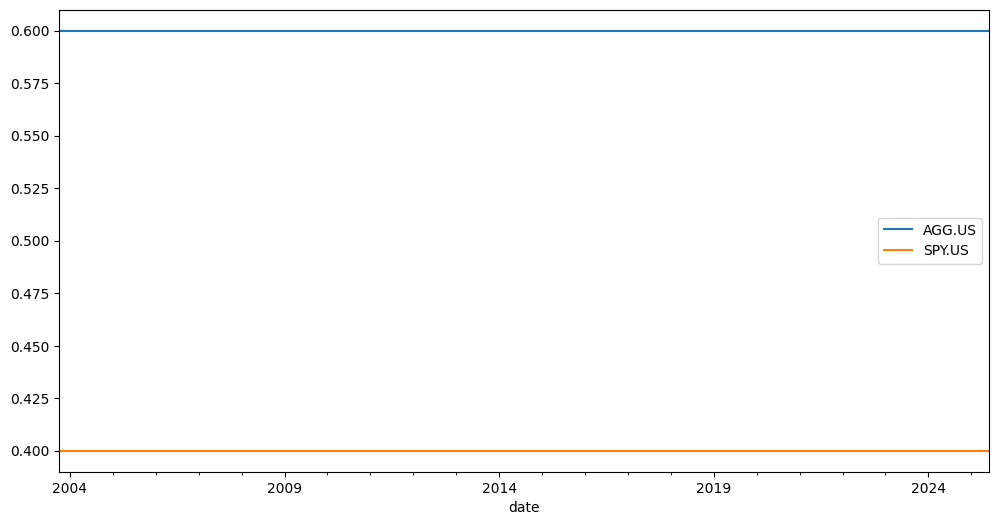

In [10]:
pf2.weights_ts.plot();

And this is exactly how it has always been presented in the classical Modern Portfolio Theory (MPT) of Markowitz. However, in real live the weights changes.

The opposite case is when the weights change without constraints (not rebalanced portfolio).


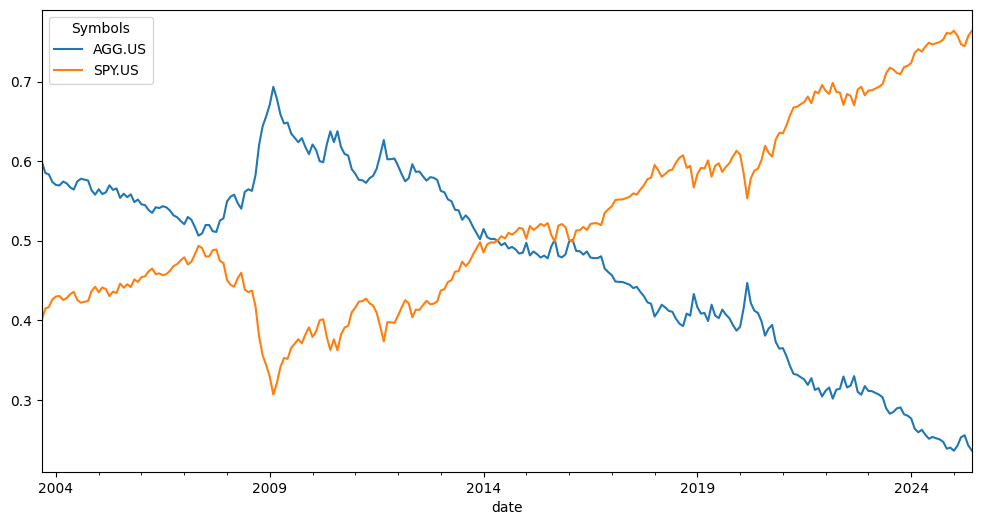

In [11]:
# change the rebalancing strategy
pf2.rebalancing_strategy = no_reb
# plot the weights
pf2.weights_ts.plot();

Over several years, the conservative portfolio became aggressive as stock allocations grew.

In [12]:
abs(pf2.weights_ts - target_weights)["SPY.US"].max()

np.float64(0.36386060365553763)

The weights deviate 36% from the initial allocation.

We can switch the rebalancing strategy in an existing portfolio to calendar-based rebalancing (annual frequency).

In [13]:
pf2.rebalancing_strategy = reb_calendar
pf2

symbol                        portfolio_1097.PF
assets                         [AGG.US, SPY.US]
weights                              [0.6, 0.4]
rebalancing_period                         year
rebalancing_abs_deviation                  None
rebalancing_rel_deviation                  None
currency                                    USD
inflation                                  None
first_date                              2003-10
last_date                               2025-06
period_length                21 years, 9 months
dtype: object

... and see the rebalancing events time series:

In [14]:
ev = pf2.rebalancing_events
ev

2003-12    calendar
2004-12    calendar
2005-12    calendar
2006-12    calendar
2007-12    calendar
2008-12    calendar
2009-12    calendar
2010-12    calendar
2011-12    calendar
2012-12    calendar
2013-12    calendar
2014-12    calendar
2015-12    calendar
2016-12    calendar
2017-12    calendar
2018-12    calendar
2019-12    calendar
2020-12    calendar
2021-12    calendar
2022-12    calendar
2023-12    calendar
2024-12    calendar
Freq: M, dtype: object

In [15]:
ev.shape  # 22 rebalancing events

(22,)

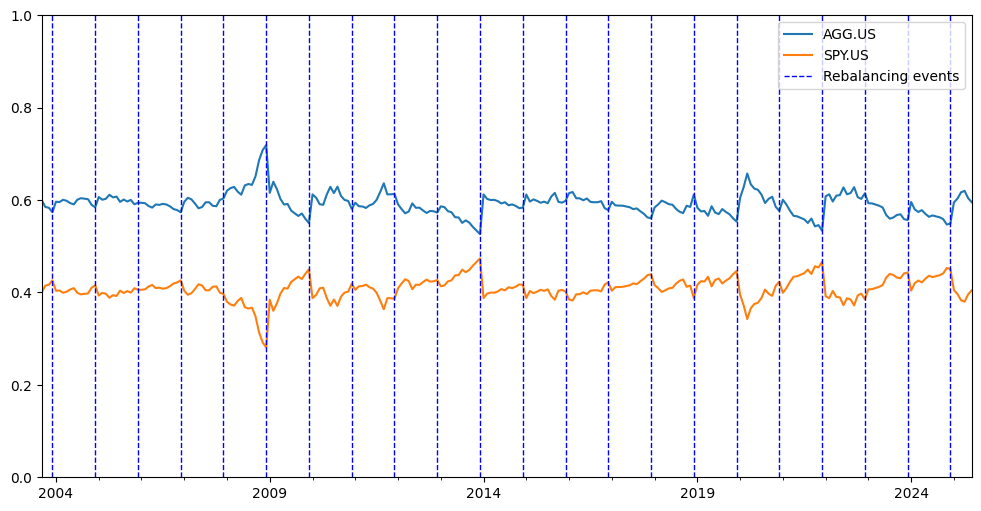

In [16]:
fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
pf2.weights_ts.plot(ax=ax)
ax.vlines(x=ev[ev == "calendar"].index, ymin=0, ymax=1, colors="blue", ls="--", lw=1, label="Rebalancing events")
ax.set_ylim([0, 1])
ax.legend();

In [17]:
abs(pf2.weights_ts - target_weights)["SPY.US"].nlargest(n=5)

2008-12   0.11911
2008-11   0.10792
2008-10   0.08642
2013-12   0.07366
2021-12   0.06630
Freq: M, Name: SPY.US, dtype: float64

The maximum asset weight deviation occurred in 2008 during the financial crisis, reaching almost 12%. This was significantly lower than in the non-rebalanced scenario.

Let's see what happens if we set the rebalancing bands with an absolute limit of 5%.

In [18]:
pf2.rebalancing_strategy = reb_bands_abs
pf2

symbol                        portfolio_1097.PF
assets                         [AGG.US, SPY.US]
weights                              [0.6, 0.4]
rebalancing_period                         none
rebalancing_abs_deviation               0.05000
rebalancing_rel_deviation                  None
currency                                    USD
inflation                                  None
first_date                              2003-10
last_date                               2025-06
period_length                21 years, 9 months
dtype: object

In [19]:
ev = pf2.rebalancing_events
ev

2005-11    abs
2008-10    abs
2009-01    abs
2009-09    abs
2011-04    abs
2011-09    abs
2012-03    abs
2013-10    abs
2016-11    abs
2018-01    abs
2021-02    abs
2021-12    abs
2024-03    abs
Freq: M, dtype: object

In [20]:
ev.shape

(13,)

13 rebalancings occurred during the historical period - fewer than the 22 required under calendar-based rebalancing. In real-world finance, each rebalancing incurs costs (brokerage commissions, taxes). This represents substantial savings...

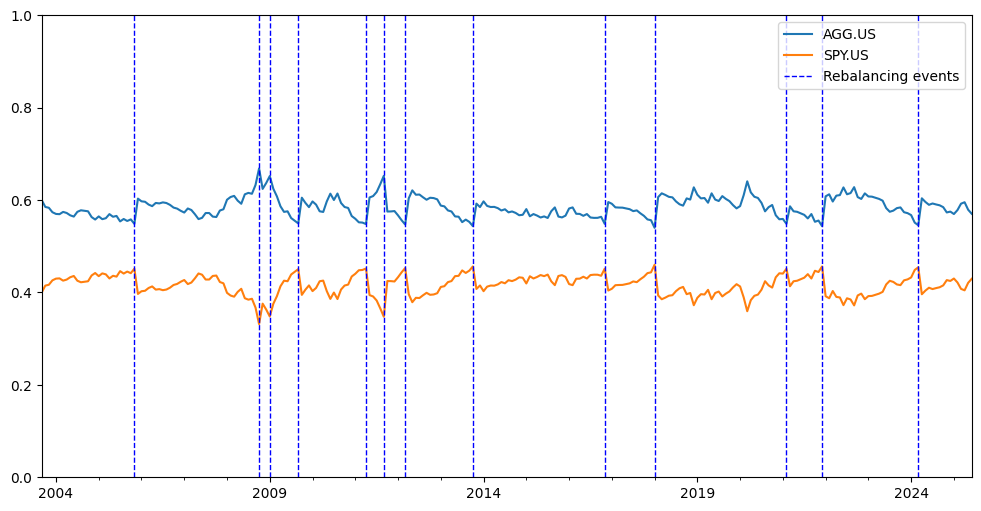

In [21]:
fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
pf2.weights_ts.plot(ax=ax)
ax.vlines(x=ev[ev == "abs"].index, ymin=0, ymax=1, colors="blue", ls="--", lw=1, label="Rebalancing events")
ax.set_ylim([0, 1])
ax.legend();

In [22]:
abs(pf2.weights_ts - target_weights)["SPY.US"].nlargest(n=5)

2008-10   0.06849
2018-01   0.06004
2021-12   0.05638
2013-10   0.05638
2024-03   0.05448
Freq: M, Name: SPY.US, dtype: float64

Weight deviations are now under control. The maximum deviation reached 6.9% - nearly half of what occurred with calendar rebalancing. Interestingly, this still exceeds the strategy's 5% limit. This occurs because okama checks rebalancing conditions at month-end (using monthly data). Within a single month, asset weights can drift beyond the strategy's prescribed limits.

### 3 assets Portfolio with small allocation

We can test the same rebalancing strategy with absolute weight deviation limits in a 3-asset portfolio, where one asset (gold) has just a 5% allocation.

In [23]:
# set target weights for the assets
target_weights3 = [0.60, 0.35, 0.05]
# set the rebalancing strategy
rs3 = ok.Rebalance(
    period="none", 
    abs_deviation=0.10, 
    rel_deviation=None
    )

# make a portfolio with 3 assets
pf3 = ok.Portfolio(
    ["SP500TR.INDX", "VBMFX.US", "GC.COMM"],
    weights=target_weights3,
    ccy="USD",
    rebalancing_strategy=rs3,
    inflation=False,
)
pf3

symbol                                       portfolio_5511.PF
assets                       [SP500TR.INDX, VBMFX.US, GC.COMM]
weights                                      [0.6, 0.35, 0.05]
rebalancing_period                                        none
rebalancing_abs_deviation                              0.10000
rebalancing_rel_deviation                                 None
currency                                                   USD
inflation                                                 None
first_date                                             1988-02
last_date                                              2025-07
period_length                               37 years, 6 months
dtype: object

During backtesting, the rebalancing condition was triggered 8 times.

In [24]:
ev3 = pf3.rebalancing_events
ev3

1995-07    abs
1997-07    abs
2002-09    abs
2007-01    abs
2008-10    abs
2013-12    abs
2018-08    abs
2023-06    abs
Freq: M, dtype: object

In [25]:
ev3.count()

np.int64(8)

We can se these rebalancing events in the chart.

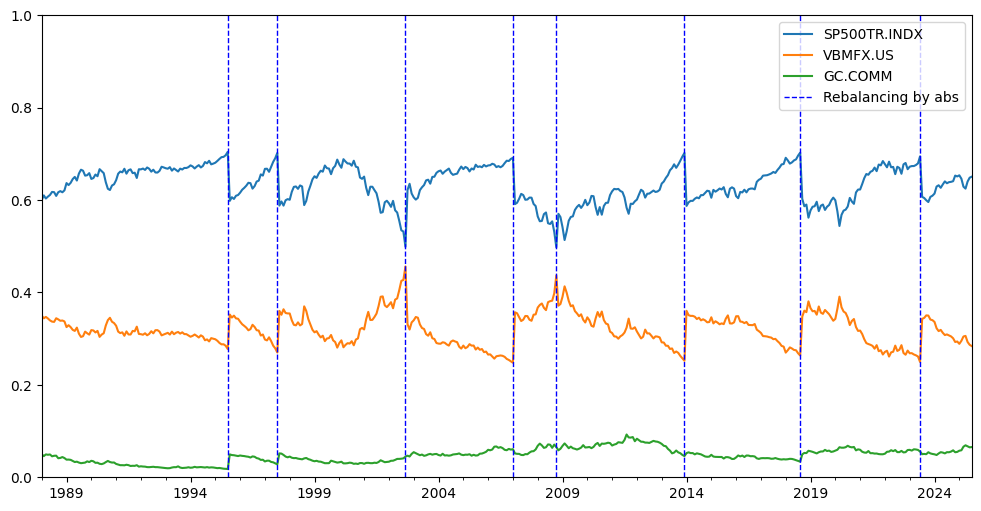

In [26]:
fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
pf3.weights_ts.plot(ax=ax)
ax.vlines(x=ev3.index, ymin=0, ymax=1, colors="blue", ls="--", lw=1, label="Rebalancing by abs")
ax.set_ylim([0, 1])
ax.legend();

However there were situations when the deviation for gold was large. The max deviation is 4,3% which is almost double (!) from the target allocation.

In [27]:
abs(pf3.weights_ts - target_weights3).max()

Symbols
SP500TR.INDX   0.10438
VBMFX.US       0.10642
GC.COMM        0.04257
dtype: float64

In this case we should add relative deviation band.

In [28]:
pf3.rebalancing_strategy = ok.Rebalance(period="none", abs_deviation=0.10, rel_deviation=0.30)  # new band

The number of rebalancing increased to 14.

In [29]:
ev3 = pf3.rebalancing_events
ev3.shape

(14,)

In [30]:
ev3

1989-05    rel
1992-04    rel
1996-06    rel
1997-07    rel
1999-01    rel
2002-07    abs
2006-01    rel
2008-01    rel
2008-12    abs
2011-07    rel
2013-06    rel
2017-10    abs
2021-08    abs
2025-03    rel
Freq: M, dtype: object

Now we have 10 rebalancings by relative band and only 4 by absolute.

In [31]:
ev3[ev3 == "rel"].count()

np.int64(10)

In [32]:
ev3[ev3 == "abs"].count()

np.int64(4)

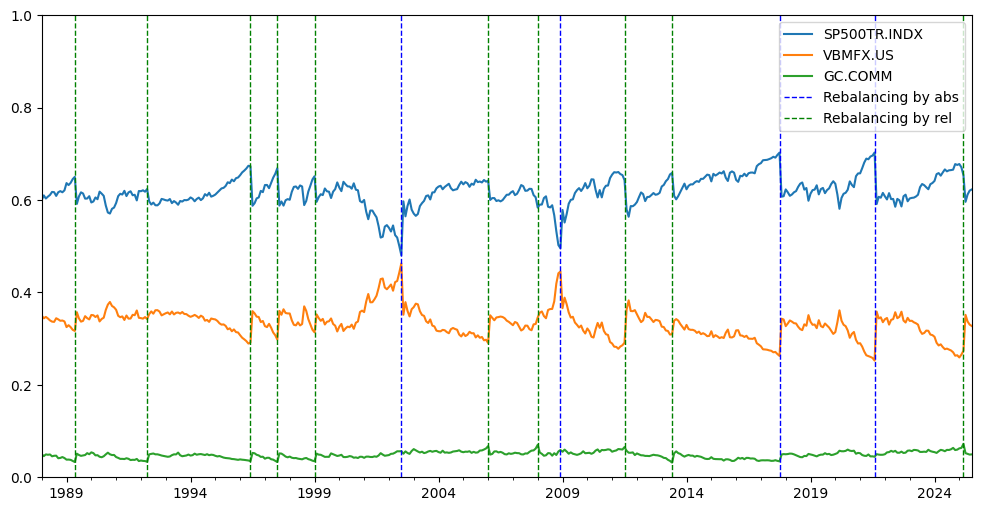

In [33]:
fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
pf3.weights_ts.plot(ax=ax)
ax.vlines(x=ev3[ev3 == "abs"].index, ymin=0, ymax=1, colors="blue", ls="--", lw=1, label="Rebalancing by abs")
ax.vlines(x=ev3[ev3 == "rel"].index, ymin=0, ymax=1, colors="green", ls="--", lw=1, label="Rebalancing by rel")
ax.set_ylim([0, 1])
ax.legend();

Now the max deviation of gold is 2,2%. And it looks better.

In [34]:
abs(pf3.weights_ts - target_weights3).max()

Symbols
SP500TR.INDX   0.11948
VBMFX.US       0.11295
GC.COMM        0.02217
dtype: float64

Now we can test an alternative approach: implementing calendar-based rebalancing that only triggers when absolute or relative deviation thresholds are breached. This hybrid method is commonly used in practice, eliminating the need for constant weight monitoring. Instead, investors simply review their allocation once a year (or once a half-year).

In [35]:
pf3.rebalancing_strategy = ok.Rebalance(period="year", abs_deviation=0.10, rel_deviation=0.20)

The number of rebalancing events has increase by 2.

In [36]:
ev3 = pf3.rebalancing_events
ev3.shape

(16,)

In the table we can see that rebalncings happen only in december.

In [37]:
ev3

1989-12    rel
1991-12    rel
1995-12    rel
1997-12    rel
1999-12    rel
2001-12    rel
2002-12    rel
2006-12    rel
2007-12    rel
2008-12    abs
2011-12    rel
2013-12    abs
2015-12    rel
2019-12    rel
2021-12    rel
2024-12    rel
Freq: M, dtype: object

Most of then are triggered by the relative band. If one feel safe with larger deviations the number of events can be reduced by adjusting the `rel_deviation` parameter.

In [38]:
ev3[ev3 == "rel"].count()

np.int64(14)

In [39]:
ev3[ev3 == "abs"].count()

np.int64(2)

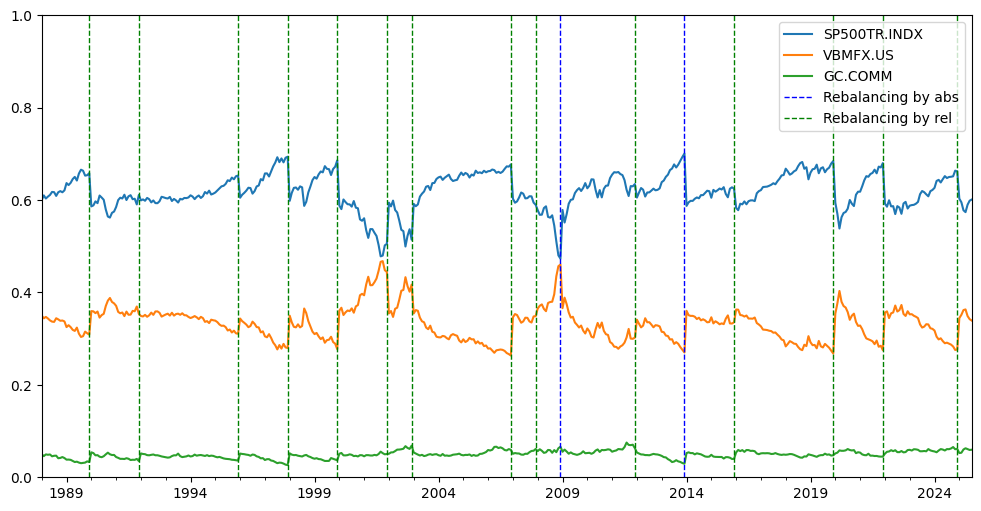

In [40]:
fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
pf3.weights_ts.plot(ax=ax)
ax.vlines(x=ev3[ev3 == "abs"].index, ymin=0, ymax=1, colors="blue", ls="--", lw=1, label="Rebalancing by abs")
ax.vlines(x=ev3[ev3 == "rel"].index, ymin=0, ymax=1, colors="green", ls="--", lw=1, label="Rebalancing by rel")
ax.set_ylim([0, 1])
ax.legend()

In the chart we can see that there were several long periods without rebalancing (good for saving).

And the max deviation is still under control.

In [41]:
abs(pf3.weights_ts - target_weights3).max()

Symbols
SP500TR.INDX   0.12670
VBMFX.US       0.11787
GC.COMM        0.02512
dtype: float64

For a passive investment approach, where the need for portfolio rebalancing is checked without automation tools, a hybrid approach with long intervals (a year or half a year) is convenient in one sense, as it eliminates the need to constantly monitor weight deviations. On the other hand, deviation bands still prevent the portfolio from straying too far from the intended strategy.

At the same time, the larger the allowed weight deviations, the greater the potential bonus from rebalancing in the form of additional returns.